In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths
from mtcnn import MTCNN
import cv2
import zipfile
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#1. Tiền xử lý dữ liệu

In [4]:
# dataset_path = '/content/drive/MyDrive/PROJECT/ImagePreprocessing/Nhan_dang_khuon_mat/dataset_image.zip'

# zip_ref = zipfile.ZipFile(dataset_path, 'r')
# zip_ref.extractall('/tmp/training')

In [2]:
dataset = 'dataset'

imagePaths = list(paths.list_images(dataset))

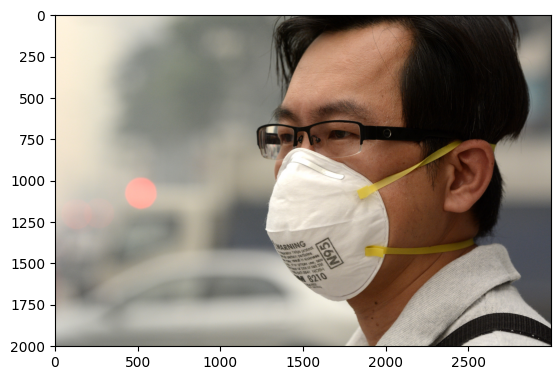

In [3]:
img = cv2.imread(imagePaths[1:2][0])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []
# khởi tạo list rỗng: chứa các nhãn của bức ảnh 
labels = []

# Chỉ sử dụng 1000 bức ảnh đầu tiên và 1000 bước ảnh cuối cùng tương ứng với đường dẫn imagePaths
for i in imagePaths[-1000:] + imagePaths[:1000]:
    
    label = i.split(os.path.sep)[-2]
    # Chèn các dữ liệu nhãn vào list labels
    labels.append(label)
    
    # Sử dụng hàm load_img để tạo mảng chứa dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224)) 
    image = img_to_array(image)
    # Chèn các dữ liệu ảnh vào list data
    data.append(image)
    
# mã hóa list dữ liệu thành định dạng mảng NumPy    
data = np.array(data,dtype='float32')
labels = np.array(labels)

In [5]:
data.shape

(2000, 224, 224, 3)

In [6]:
# Mã hóa nhị phân cho 2 loại nhãn
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = to_categorical(labels)

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size = 0.25, stratify = labels, random_state = 42)
val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.3, stratify = test_Y, random_state = 42)

In [8]:
train_X.shape, train_Y.shape

((1500, 224, 224, 3), (1500, 2))

In [9]:
val_X.shape, val_Y.shape

((350, 224, 224, 3), (350, 2))

In [10]:
test_X.shape, test_Y.shape

((150, 224, 224, 3), (150, 2))

# Khởi tạo và huấn luyện mô hình

In [11]:
#khởi tạo hàm tăng cường dữ liệu
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode="nearest")

In [12]:
#Khởi tạo mô hình base EfficientNetB0
baseModel = tf.keras.applications.EfficientNetB0(weights="imagenet",include_top=False, input_tensor = Input(shape = (224, 224, 3)))

In [13]:
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name="Flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

In [14]:
#Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet
for layer in baseModel.layers:
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [17]:
learning_rate = 0.001
Epochs = 3
BS = 32

# Khởi tạo thuật toán tối ưu Adam
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=learning_rate/Epochs)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer = opt, metrics = [tf.keras.metrics.AUC()])

H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)

Epoch 1/3
46/46 [==============================] - 125s 3s/step - loss: 0.1799 - auc: 0.9798 - val_loss: 0.1348 - val_auc: 0.9757
Epoch 2/3
46/46 [==============================] - 101s 2s/step - loss: 0.1164 - auc: 0.9864 - val_loss: 0.0976 - val_auc: 0.9874
Epoch 3/3
46/46 [==============================] - 96s 2s/step - loss: 0.0908 - auc: 0.9886 - val_loss: 0.0927 - val_auc: 0.9879


In [18]:
tf.keras.models.save_model(model, 'save_model')

INFO:tensorflow:Assets written to: save_model\assets


INFO:tensorflow:Assets written to: save_model\assets


In [19]:
H.history

{'loss': [0.17988230288028717, 0.11635678261518478, 0.09081483632326126],
 'auc': [0.9797695279121399, 0.9864428639411926, 0.9885684847831726],
 'val_loss': [0.134761244058609, 0.09762660413980484, 0.0927395224571228],
 'val_auc': [0.9757305383682251, 0.987432599067688, 0.9878610968589783]}

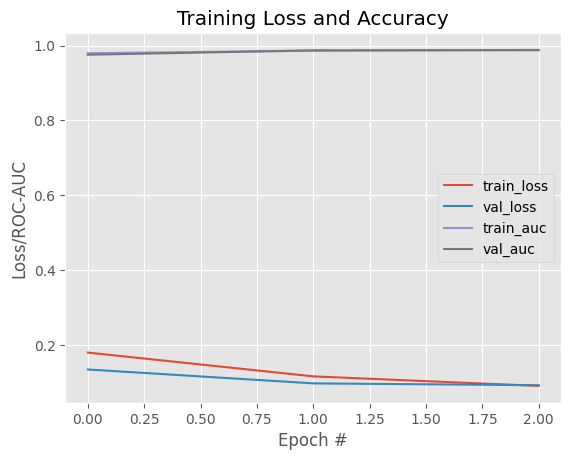

In [21]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

# Thử nghiệm trên ảnh thật

In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import cv2
model = load_model('save_model')

In [3]:
detector = MTCNN()

def mask_detect(image):
    img = image.copy()
    (h,w) = img.shape[:2]
    detected_imgs = detector.detect_faces(img)
    for detected_img in detected_imgs:
      boxes = detected_img['box']
      topLeftX,topLeftY,wight,hight=boxes

      #ensure the bounding boxes fall within the dimensions of the frame
      (topLeftX,topLeftY)=(max(0,topLeftX),max(0,topLeftY))
      (wight,hight)=(min(w-1,wight), min(h-1,hight))


      #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
      face=img[topLeftY:topLeftY+hight, topLeftX:topLeftX+wight]
      face=cv2.resize(face,(224,224))

      (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

      #determine the class label and color we will use to draw the bounding box and text
      label='Mask' if mask>withoutMask else 'No Mask'
      color=(0,255,0) if label=='Mask' else (0,0,255)

      #include the probability in the label
      label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

      #display the label and bounding boxes
      cv2.putText(img,label,(topLeftX,topLeftY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
      cv2.rectangle(img,(topLeftX,topLeftY),(topLeftX+wight,topLeftY+hight),color,2)
    return img

def predict_image(dir):
    img = cv2.imread(dir)
    img = mask_detect(img)

    plt.imshow(img[:, :, ::-1])
    plt.grid(False)
    cv2.imshow("OutPut",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

1/1 [==============================] - 1s 1s/step


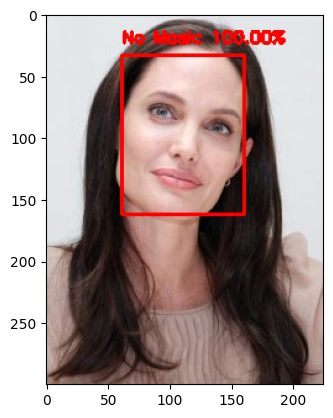

In [4]:
predict_image("image/angelina.jpg")

1/1 [==============================] - 0s 87ms/step


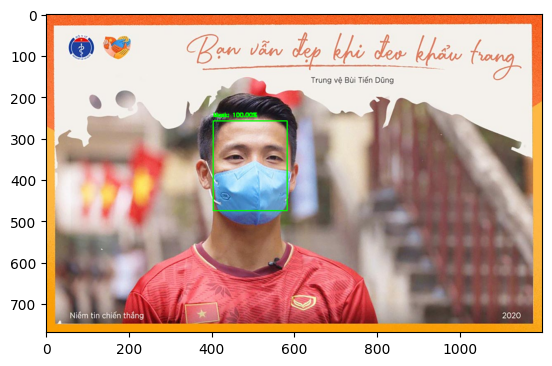

In [6]:
predict_image("image/anh.jpg")

1/1 [==============================] - 0s 63ms/step


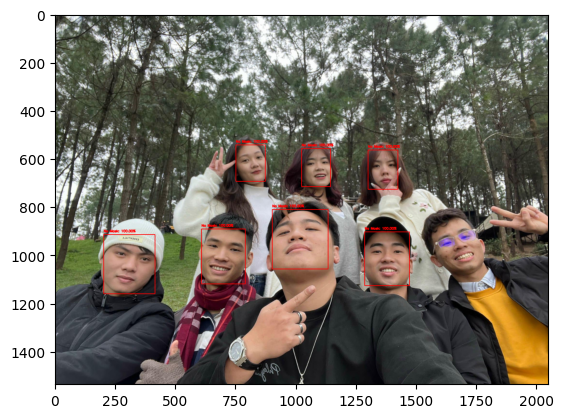

In [5]:
predict_image("image/new.jpg")

# Video

In [8]:
from imutils.video import VideoStream
import imutils

In [10]:
vs = cv2.VideoCapture(0)

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame = vs.read()[1]
    (h, w) = frame.shape[:2]
    detected_imgs = detector.detect_faces(frame)
    for detected_img in detected_imgs:
      boxes = detected_img['box']
      topLeftX,topLeftY,wight,hight=boxes

      #ensure the bounding boxes fall within the dimensions of the frame
      (topLeftX,topLeftY)=(max(0,topLeftX),max(0,topLeftY))
      (wight,hight)=(min(w-1,wight), min(h-1,hight))


      #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
      face=frame[topLeftY:topLeftY+hight, topLeftX:topLeftX+wight]
      face=cv2.resize(face,(224,224))

      (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

      #determine the class label and color we will use to draw the bounding box and text
      label='Mask' if mask>withoutMask else 'No Mask'
      color=(0,255,0) if label=='Mask' else (0,0,255)

      #include the probability in the label
      label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

      #display the label and bounding boxes
      cv2.putText(frame,label,(topLeftX,topLeftY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
      cv2.rectangle(frame,(topLeftX,topLeftY),(topLeftX+wight,topLeftY+hight),color,2)
        
    #show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        break
        
cv2.destroyAllWindows()

1/1 [==============================] - 0s 78ms/step
